In [1]:
import torch


from model_architectures import MonaiDDPM, MonaiDDPM_unconditional
device = "cuda:0" if torch.cuda.is_available() else "cpu"


CONDITIONAL = True
RESOLUTION = 256

T = 1_000     

ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/025_MNIST_basic_DDPM/checkpoints/ddpm-epoch=08-train_loss=0.0017.ckpt" # MNIST EXAMPLE> WORKED WELL.
ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/026_DDPM_revamped/checkpoints/ddpm-epoch=01-train_loss=0.3648.ckpt" # 
ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/027_DDPM_MONAI/checkpoints/ddpm-epoch=09-step=39210.ckpt"
ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/031_DDPM_classifier-free-test/checkpoints/epoch=09-step=9810.ckpt"
# ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/032_cDDPM_512x512-test-prog/checkpoints/best_64px.ckpt"
ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/037_cDDPM_256x256/checkpoints/epoch=22-step=7843.ckpt"
# ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/041_cDDPM_128x128/checkpoints/epoch=16-step=5797.ckpt"
# ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/045_DDPM_deeper_unconditional_64x64/checkpoints/epoch=16-step=5797.ckpt"
ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/047_cDDPM_depth5_256x256/checkpoints/epoch=27-step=9548.ckpt"

if CONDITIONAL:
    model = MonaiDDPM.load_from_checkpoint(
        ckpt_path
    ).to(device).eval()
else:
    model = MonaiDDPM_unconditional.load_from_checkpoint(
        ckpt_path
    ).to(device).eval()

Error importing huggingface_hub.file_download: 'Version'


/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Initialized conditional model.


In [2]:
if CONDITIONAL:
    nb_images = 16
    with torch.no_grad():
        samples = model.sample(
            N=nb_images,
            label=1,
            size=RESOLUTION,
            guidance_scale=4.0
        )
else:
    nb_images = 16
    with torch.no_grad():
        samples = model.sample(
            N=nb_images,
            size=RESOLUTION,
        )
    image, intermediates = samples
    chain = torch.cat(intermediates, dim=-1)
    


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:26<00:00,  1.17s/it]


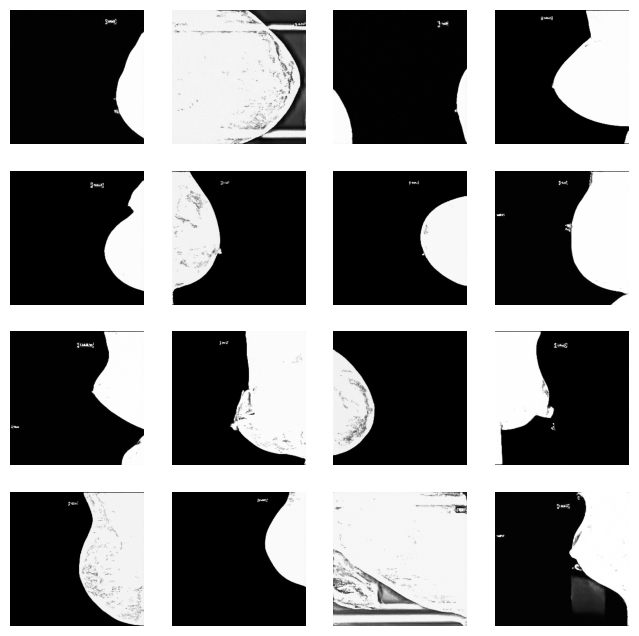

In [4]:
import matplotlib.pyplot as plt

if CONDITIONAL:
    # out_dir = ckpt_path.parent / "inference_samples"
    # out_dir.mkdir(exist_ok=True)
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.axis('off')
        plt.imshow(samples[i, 0].cpu(), cmap='gray', vmin=0, vmax=1)
        # plt.imsave(out_dir / f"sample_{i:02d}.png", img_np, cmap="gray")
    plt.savefig('./inference_snapshots/samples_grid.png', dpi=300)  # Save at 300 DPI
    plt.show()
    
else:
    plt.style.use("default")
    plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.show()
